import data:

In [21]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
df = pd.read_csv('C:\workdir\creditcard.csv')

skálázás ás metadata:

In [22]:
from sklearn.preprocessing import RobustScaler
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
scaler = RobustScaler()

df['amount_scaled'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['time_scaled'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)
df.head()

metadata.detect_from_dataframe(data=df)
metadata.validate()
python_dict = metadata.to_dict()
print(python_dict)

{'columns': {'V1': {'sdtype': 'numerical'}, 'V2': {'sdtype': 'numerical'}, 'V3': {'sdtype': 'numerical'}, 'V4': {'sdtype': 'numerical'}, 'V5': {'sdtype': 'numerical'}, 'V6': {'sdtype': 'numerical'}, 'V7': {'sdtype': 'numerical'}, 'V8': {'sdtype': 'numerical'}, 'V9': {'sdtype': 'numerical'}, 'V10': {'sdtype': 'numerical'}, 'V11': {'sdtype': 'numerical'}, 'V12': {'sdtype': 'numerical'}, 'V13': {'sdtype': 'numerical'}, 'V14': {'sdtype': 'numerical'}, 'V15': {'sdtype': 'numerical'}, 'V16': {'sdtype': 'numerical'}, 'V17': {'sdtype': 'numerical'}, 'V18': {'sdtype': 'numerical'}, 'V19': {'sdtype': 'numerical'}, 'V20': {'sdtype': 'numerical'}, 'V21': {'sdtype': 'numerical'}, 'V22': {'sdtype': 'numerical'}, 'V23': {'sdtype': 'numerical'}, 'V24': {'sdtype': 'numerical'}, 'V25': {'sdtype': 'numerical'}, 'V26': {'sdtype': 'numerical'}, 'V27': {'sdtype': 'numerical'}, 'V28': {'sdtype': 'numerical'}, 'Class': {'sdtype': 'numerical'}, 'amount_scaled': {'sdtype': 'numerical'}, 'time_scaled': {'sdtype'

In [23]:
X = df.drop('Class', axis=1)
y = df['Class']

df = df.sample(frac=1)

df_fraud = df.loc[df['Class'] == 1]
df_not_fraud = df.loc[df['Class'] == 0][:28000]

df_normal_dist = pd.concat([df_fraud, df_not_fraud])
new_df = df_normal_dist.sample(frac=1)
new_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,amount_scaled,time_scaled
34413,-1.629788,-6.446942,-0.591726,0.279617,-3.739444,0.274084,0.534492,-0.334545,-0.991046,0.469633,...,-1.295425,-1.308443,0.439826,-0.337614,-0.410262,-0.226396,0.306201,0,22.125480,-0.552603
66839,-1.288576,0.411500,0.304297,-1.531243,3.581805,-1.784578,-5.446399,-5.336273,0.662655,-1.894025,...,-0.249006,-6.256749,-0.659967,0.661266,-0.598567,0.267840,0.367275,0,-0.293440,-0.381231
156535,1.451676,-0.855729,-2.408475,0.612836,0.441058,-0.908269,0.960028,-0.476497,1.288091,-0.263145,...,0.236405,-0.293801,0.730004,0.316571,-0.223595,-0.164514,-0.027974,0,4.320548,0.277729
245627,-0.027337,0.508518,0.800399,-0.105142,-0.532230,-0.063714,0.137582,0.202320,0.684735,-0.929000,...,0.524334,0.138131,-0.121423,-1.118632,-0.518090,0.105572,0.130091,0,0.685111,0.800573
41663,1.354703,-0.494155,0.239957,-0.084800,-0.362576,0.552868,-0.579802,0.024411,-0.538552,0.509052,...,-0.617191,-0.104237,-0.911630,0.545274,0.501951,0.034834,0.006531,0,-0.146720,-0.515937


Conditions:

In [24]:
from sdv.sampling import Condition

frauds = Condition(
    num_rows=25000,
    column_values={'Class': 1}
)

non_frauds = Condition(
    num_rows=25000,
    column_values={'Class': 0}
)

Generate CTGAN

In [26]:
from sdv.single_table import CTGANSynthesizer

ctgan_synthesizer = CTGANSynthesizer(metadata)
ctgan_synthesizer.fit(new_df)
ctgan_synthesizer.save(
    filepath='ctgan_synthesizer.pkl'
)
ctgan_df = ctgan_synthesizer.sample_from_conditions(conditions=[frauds,non_frauds])
ctgan_df.head()


Sampling conditions: 100%|██████████| 50000/50000 [02:20<00:00, 356.06it/s] 


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,amount_scaled,time_scaled
0,-14.481154,4.234052,-13.339060,6.225731,-19.371045,-0.823466,-26.450187,1.970656,-5.537222,-10.430350,...,0.239490,2.796066,0.156715,1.254644,-0.075297,1.150221,0.186793,1,3.754444,-0.435665
1,-1.449144,2.515694,-11.250406,0.411488,0.126996,0.221824,-24.525354,1.406943,-0.408128,-1.560335,...,-0.167546,-0.060876,-0.212430,-0.098984,0.065220,0.090324,0.129985,1,-0.255219,0.195492
2,-4.414209,1.009164,-0.289560,2.507378,2.479775,0.273132,-19.099711,8.935564,-1.460020,-0.908442,...,0.088821,-0.081369,-0.308101,-0.149761,0.108745,0.158952,0.043559,1,-0.269521,0.301141
3,-6.405312,6.560189,-14.862391,7.061231,-6.935566,-1.189397,-15.863170,1.220050,-7.662113,-2.396192,...,1.180651,-0.252344,-1.143926,0.381603,0.695496,1.340810,0.152250,1,-0.307413,0.448941
4,-15.184021,3.198961,-6.697173,13.887874,3.374498,-5.271103,-25.442108,4.341177,-8.057133,-6.028626,...,0.703236,-0.261064,0.594291,0.268963,0.456568,0.725037,0.237056,1,-0.307413,0.667962


Load CTGAN

In [27]:
"""ctgan_synthesizer = CTGANSynthesizer.load(
    filepath='ctgan_synthesizer.pkl'
)
ctgan_df = ctgan_synthesizer.sample_from_conditions(conditions=[frauds,non_frauds])
ctgan_df.head()"""

"ctgan_synthesizer = CTGANSynthesizer.load(\n    filepath='ctgan_synthesizer.pkl'\n)\nctgan_df = ctgan_synthesizer.sample_from_conditions(conditions=[frauds,non_frauds])\nctgan_df.head()"

TVAE:

In [28]:
from sdv.single_table import TVAESynthesizer

tvae_synthesizer = TVAESynthesizer(metadata)
tvae_synthesizer.fit(new_df)

tvae_synthesizer.save(
    filepath='tvae_synthesizer.pkl'
)
tvae_df = tvae_synthesizer.sample_from_conditions(conditions=[frauds,non_frauds])
tvae_df.head()

Sampling conditions: 100%|██████████| 50000/50000 [03:13<00:00, 258.40it/s] 


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,amount_scaled,time_scaled
0,-5.313272,-12.112503,-3.711475,1.156134,-1.804285,-3.778101,-2.490534,-0.223705,1.180112,-1.687640,...,0.971295,-0.388929,-0.306804,-1.743711,-0.067422,-2.161941,-1.821046,1,9.349570,0.877183
1,-0.650272,1.494479,0.310521,1.156502,0.364922,0.051407,1.001756,0.121787,-0.709408,-1.619896,...,0.222665,-0.135598,0.476446,-0.052725,-0.159355,0.315003,0.150720,1,-0.272953,-0.221457
2,-0.966994,1.505868,-0.858655,1.134084,-0.241551,-0.892189,-1.388590,-2.236105,-1.268902,-2.241698,...,0.482176,-0.589451,-0.603490,0.348425,-0.325247,-0.082376,0.186467,1,0.458258,-0.248766
3,0.862862,6.448998,-14.733214,10.465481,-5.061743,-0.603376,-1.284472,-0.090573,-1.556751,-4.388770,...,0.798433,0.012334,0.333102,-0.614691,0.185453,0.598464,0.104421,1,1.606581,0.729252
4,-0.738298,5.438613,-5.221816,3.898601,0.704763,-1.058601,-6.710502,-1.793823,-1.385025,-6.471002,...,1.372957,-0.160182,0.343339,0.613991,0.331055,0.376450,0.252324,1,-0.070168,0.908722


TVAE load:

In [29]:
"""tvae_synthesizer = TVAESynthesizer.load(
    filepath='tvae_synthesizer.pkl'
)

tvae_df = tvae_synthesizer.sample_from_conditions(conditions=[frauds,non_frauds])
tvae_df.head()"""

"tvae_synthesizer = TVAESynthesizer.load(\n    filepath='tvae_synthesizer.pkl'\n)\n\ntvae_df = tvae_synthesizer.sample_from_conditions(conditions=[frauds,non_frauds])\ntvae_df.head()"

Evaluate the two synthetic dataframes:

In [30]:
from sdv.evaluation.single_table import evaluate_quality

quality_report_ctgan = evaluate_quality(
    real_data=new_df,
    synthetic_data=ctgan_df,
    metadata=metadata)

Creating report: 100%|██████████| 4/4 [00:08<00:00,  2.02s/it]



Overall Quality Score: 86.08%

Properties:
Column Shapes: 78.48%
Column Pair Trends: 93.68%


In [31]:
quality_report_tvae = evaluate_quality(
    real_data=new_df,
    synthetic_data=tvae_df,
    metadata=metadata)

Creating report: 100%|██████████| 4/4 [00:07<00:00,  1.98s/it]



Overall Quality Score: 88.78%

Properties:
Column Shapes: 82.0%
Column Pair Trends: 95.55%


In [32]:
from sdv.evaluation.single_table import get_column_plot

fig = get_column_plot(
    real_data=new_df,
    synthetic_data=ctgan_df,
    column_name='time_scaled',
    metadata=metadata
)
    
fig.show()

In [33]:
from sdv.evaluation.single_table import get_column_plot

fig = get_column_plot(
    real_data=new_df,
    synthetic_data=tvae_df,
    column_name='time_scaled',
    metadata=metadata
)
    
fig.show()

Csalás:  25000
Nem csalás:  25000


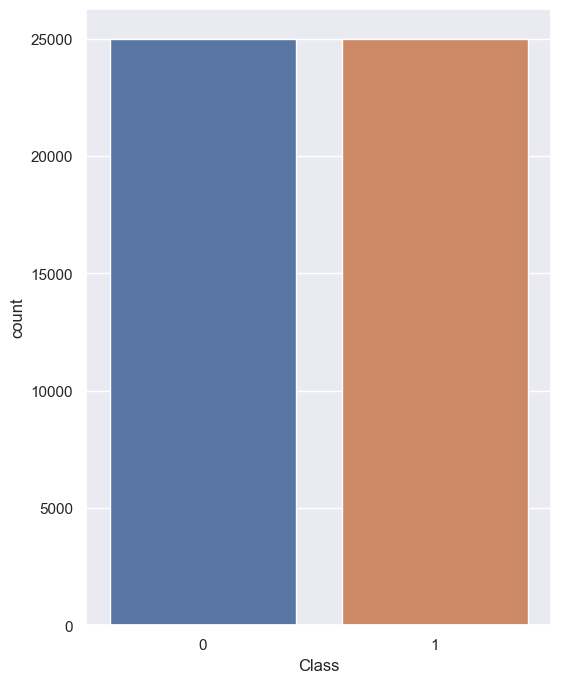

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

print('Csalás: ', ctgan_df['Class'].value_counts()[1])
print('Nem csalás: ', ctgan_df['Class'].value_counts()[0])
sns.countplot(x=ctgan_df['Class'])
plt.show()

Korreláció:

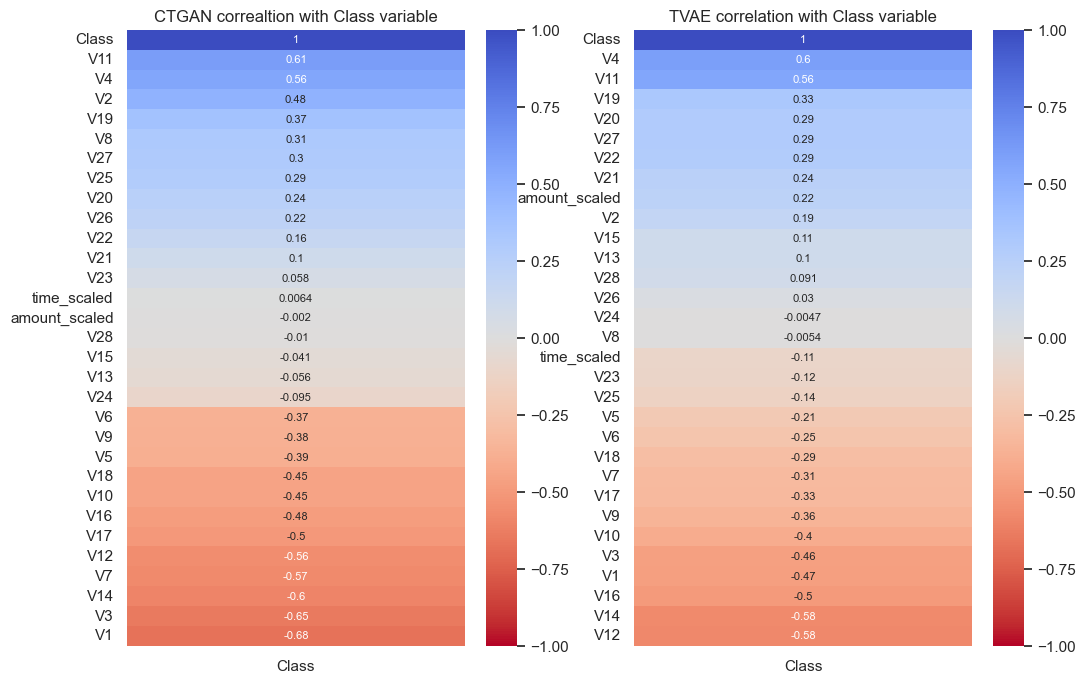

In [35]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
sns.set(font_scale=0.6)
sns.set (rc = {'figure.figsize':(6, 8)})
ax1.set_title('CTGAN correaltion with Class variable')
sns.heatmap(ctgan_df.corr()[['Class']].sort_values(by='Class', ascending=False),vmin=-1, vmax=1, annot=True, annot_kws={'size': 8}, cmap='coolwarm_r',ax=ax1)
ax2.set_title('TVAE correlation with Class variable')
sns.heatmap(tvae_df.corr()[['Class']].sort_values(by='Class', ascending=False),vmin=-1, vmax=1, annot=True, annot_kws={'size': 8}, cmap='coolwarm_r', ax=ax2)
plt.show()

Training:

In [36]:
from sklearn.model_selection import train_test_split
from collections import Counter

X_ctgan = ctgan_df.drop('Class', axis=1)
y_ctgan = ctgan_df['Class']
X_train, X_test, y_train, y_test = train_test_split(X_ctgan, y_ctgan, test_size=0.2)
print('Length of X (train): {} | Length of y (train): {}'.format(len(X_train), len(y_train)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(X_test), len(y_test)))
print(Counter(y_train))
print(Counter(y_test))

Length of X (train): 40000 | Length of y (train): 40000
Length of X (test): 10000 | Length of y (test): 10000
Counter({1: 20019, 0: 19981})
Counter({0: 5019, 1: 4981})


In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

logreg_ctgan = LogisticRegression(n_jobs=-1)
dectree_ctgan = DecisionTreeClassifier()
svc_ctgan = LinearSVC()
knear_ctgan = KNeighborsClassifier(n_jobs=-1)

In [38]:
logreg_ctgan.fit(X_train, y_train)
dectree_ctgan.fit(X_train,y_train)
svc_ctgan.fit(X_train,y_train)
knear_ctgan.fit(X_train,y_train)

KNeighborsClassifier(n_jobs=-1)

In [39]:
from sklearn.metrics import accuracy_score

logreg_pred = logreg_ctgan.predict(X_test)
svc_pred = svc_ctgan.predict(X_test)
dectree_pred = dectree_ctgan.predict(X_test)
knear_pred = knear_ctgan.predict(X_test)
print("A logisztikus regresszió modellünk pontossági pontszáma jelenleg: ",accuracy_score(y_test, logreg_pred))
print("A Support Vector Machine modellünk pontossági pontszáma jelenleg: ",accuracy_score(y_test, svc_pred))
print("A Döntési fa modellünk pontossági pontszáma jelenleg: ",accuracy_score(y_test, dectree_pred))
print("A K közelebbi szomszéd modellünk pontossági pontszáma jelenleg: ",accuracy_score(y_test, knear_pred))

A logisztikus regresszió modellünk pontossági pontszáma jelenleg:  0.9465
A Support Vector Machine modellünk pontossági pontszáma jelenleg:  0.9456
A Döntési fa modellünk pontossági pontszáma jelenleg:  0.9258
A K közelebbi szomszéd modellünk pontossági pontszáma jelenleg:  0.9439


In [40]:
X_tvae = tvae_df.drop('Class', axis=1)
y_tvae = tvae_df['Class']
X_train_tvae, X_test_tvae, y_train_tvae, y_test_tvae = train_test_split(X_tvae, y_tvae, test_size=0.2)
print('Length of X (train): {} | Length of y (train): {}'.format(len(X_train), len(y_train)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(X_test), len(y_test)))
print(Counter(y_train))
print(Counter(y_test))

Length of X (train): 40000 | Length of y (train): 40000
Length of X (test): 10000 | Length of y (test): 10000
Counter({1: 20019, 0: 19981})
Counter({0: 5019, 1: 4981})


In [41]:
logreg_tvae = LogisticRegression(n_jobs=-1)
dectree_tvae = DecisionTreeClassifier()
svc_tvae = LinearSVC()
knear_tvae = KNeighborsClassifier(n_jobs=-1)

logreg_tvae.fit(X_train_tvae, y_train_tvae)
dectree_tvae.fit(X_train_tvae,y_train_tvae)
svc_tvae.fit(X_train_tvae,y_train_tvae)
knear_tvae.fit(X_train_tvae,y_train_tvae)

logreg_pred = logreg_tvae.predict(X_test_tvae)
svc_pred = svc_tvae.predict(X_test_tvae)
dectree_pred = dectree_tvae.predict(X_test_tvae)
knear_pred = knear_tvae.predict(X_test_tvae)
print("A logisztikus regresszió modellünk pontossági pontszáma jelenleg: ",accuracy_score(y_test_tvae, logreg_pred))
print("A Support Vector Machine modellünk pontossági pontszáma jelenleg: ",accuracy_score(y_test_tvae, svc_pred))
print("A Döntési fa modellünk pontossági pontszáma jelenleg: ",accuracy_score(y_test_tvae, dectree_pred))
print("A K közelebbi szomszéd modellünk pontossági pontszáma jelenleg: ",accuracy_score(y_test_tvae, knear_pred))

A logisztikus regresszió modellünk pontossági pontszáma jelenleg:  0.9661
A Support Vector Machine modellünk pontossági pontszáma jelenleg:  0.9652
A Döntési fa modellünk pontossági pontszáma jelenleg:  0.9571
A K közelebbi szomszéd modellünk pontossági pontszáma jelenleg:  0.9761


RandomizedSearchCV:

In [44]:
from sklearn.model_selection import RandomizedSearchCV


log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = RandomizedSearchCV(LogisticRegression(n_jobs=-1), log_reg_params)
grid_log_reg.fit(X_train_tvae, y_train_tvae)
print(grid_log_reg.best_params_)
logreg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = RandomizedSearchCV(KNeighborsClassifier(n_jobs=-1), knears_params)
grid_knears.fit(X_train_tvae, y_train_tvae)
print(grid_knears.best_params_)
knear = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {"penalty": ['l1', 'l2'], 'C': [0.5, 0.7, 0.9, 1]}
grid_svc = RandomizedSearchCV(LinearSVC(), svc_params)
grid_svc.fit(X_train_tvae, y_train_tvae)
print(grid_svc.best_params_)

# SVC best estimator
svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = RandomizedSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train_tvae, y_train_tvae)
print(grid_tree.best_params_)

# tree best estimator
dectree = grid_tree.best_estimator_

{'penalty': 'l2', 'C': 1000}
{'n_neighbors': 3, 'algorithm': 'brute'}
{'penalty': 'l2', 'C': 0.7}
{'min_samples_leaf': 5, 'max_depth': 3, 'criterion': 'gini'}


In [46]:
logreg_pred = logreg.predict(X_test_tvae)
svc_pred = svc.predict(X_test_tvae)
dectree_pred = dectree.predict(X_test_tvae)
knear_pred = knear.predict(X_test_tvae)
print("A logisztikus regresszió modellünk pontossági pontszáma jelenleg: ",accuracy_score(y_test_tvae, logreg_pred))
print("A Support Vector Machine modellünk pontossági pontszáma jelenleg: ",accuracy_score(y_test_tvae, svc_pred))
print("A Döntési fa modellünk pontossági pontszáma jelenleg: ",accuracy_score(y_test_tvae, dectree_pred))
print("A K közelebbi szomszéd modellünk pontossági pontszáma jelenleg: ",accuracy_score(y_test_tvae, knear_pred))

A logisztikus regresszió modellünk pontossági pontszáma jelenleg:  0.9661
A Support Vector Machine modellünk pontossági pontszáma jelenleg:  0.9655
A Döntési fa modellünk pontossági pontszáma jelenleg:  0.9275
A K közelebbi szomszéd modellünk pontossági pontszáma jelenleg:  0.9752


In [47]:
from sklearn.metrics import classification_report
print("Logreg: ")
print(classification_report(y_test_tvae,logreg_pred))
print("SVC: ")
print(classification_report(y_test_tvae,svc_pred))
print("Knear: ")
print(classification_report(y_test_tvae,knear_pred))
print("dectree: ")
print(classification_report(y_test_tvae,dectree_pred))

Logreg: 
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      4981
           1       0.97      0.96      0.97      5019

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

SVC: 
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      4981
           1       0.97      0.96      0.97      5019

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Knear: 
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4981
           1       0.98      0.98      0.98      5019

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     100

In [48]:
from sklearn.metrics import roc_auc_score

logreg_pred = logreg.decision_function(X_test_tvae)
svc_pred = svc.decision_function(X_test_tvae)
dectree_pred = dectree.predict_proba(X_test_tvae)
knear_pred = knear.predict_proba(X_test_tvae)


print('Logistic Regression: ', roc_auc_score(y_test_tvae, logreg_pred))
print('Support Vector Classifier: ', roc_auc_score(y_test_tvae, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_test_tvae, dectree_pred[:,1]))
print('KNears Neighbors: ', roc_auc_score(y_test_tvae, knear_pred[:,1]))

Logistic Regression:  0.9937178692860325
Support Vector Classifier:  0.9935047062079577
Decision Tree Classifier:  0.9583304382915289
KNears Neighbors:  0.9887822180152281


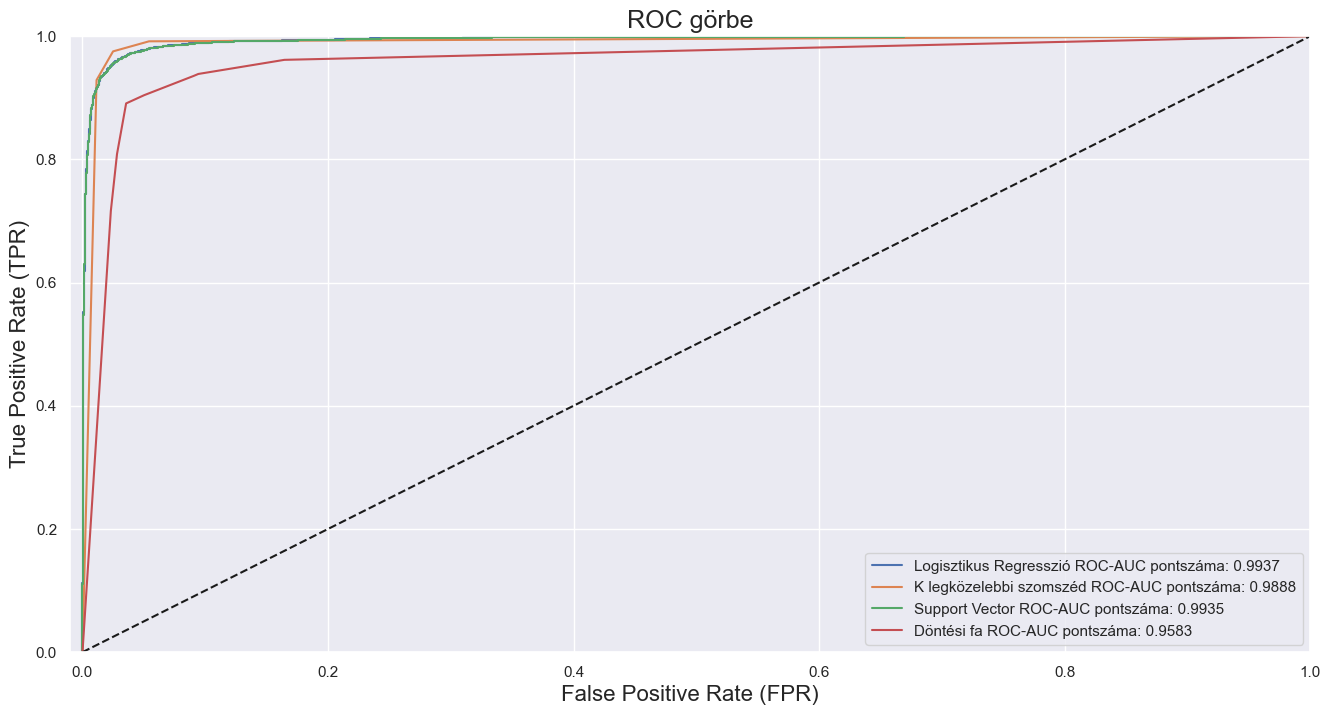

In [49]:
from sklearn.metrics import roc_curve
log_fpr, log_tpr, log_thresold = roc_curve(y_test_tvae, logreg_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_test_tvae, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_test_tvae, dectree_pred[:,1])
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_test_tvae, knear_pred[:,1])

def graph_roc_curve_multiple(log_fpr, log_tpr,knear_fpr, knear_tpr, svc_fpr, svc_tpr,tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC görbe', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logisztikus Regresszió ROC-AUC pontszáma: {:.4f}'.format(roc_auc_score(y_test_tvae, logreg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='K legközelebbi szomszéd ROC-AUC pontszáma: {:.4f}'.format(roc_auc_score(y_test_tvae, knear_pred[:,1])))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector ROC-AUC pontszáma: {:.4f}'.format(roc_auc_score(y_test_tvae, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Döntési fa ROC-AUC pontszáma: {:.4f}'.format(roc_auc_score(y_test_tvae, dectree_pred[:,1])))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)
   
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr,knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

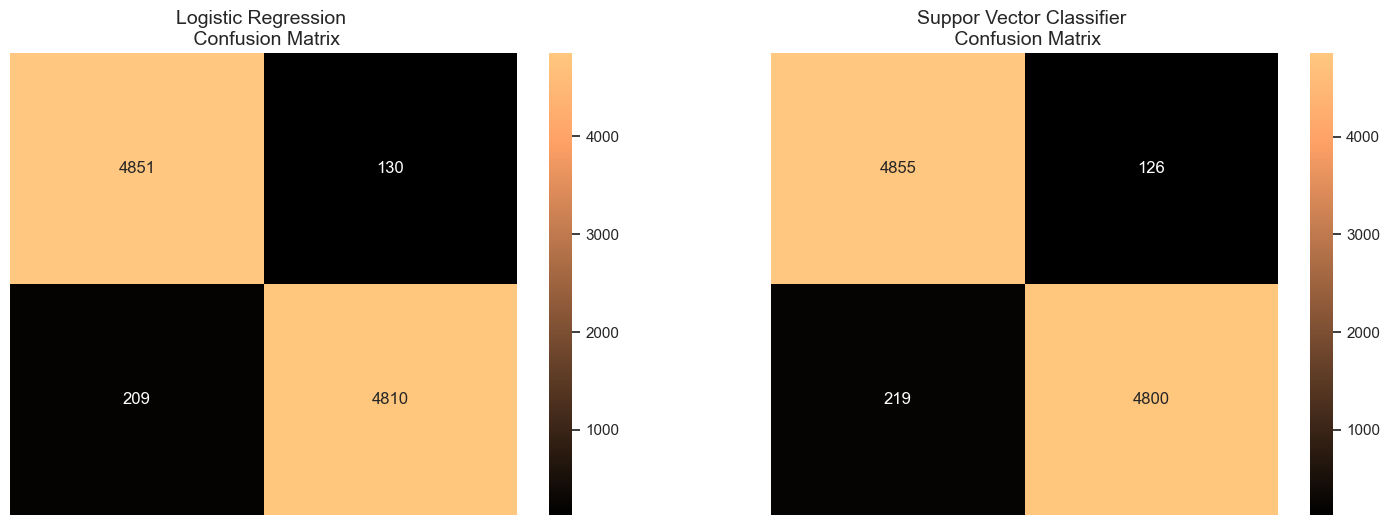

In [50]:
from sklearn.metrics import confusion_matrix

y_pred_logreg = logreg.predict(X_test_tvae)
y_pred_svc = svc.predict(X_test_tvae)


log_reg_cf = confusion_matrix(y_test_tvae, y_pred_logreg)
svc_cf = confusion_matrix(y_test_tvae, y_pred_svc)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,6))

sns.heatmap(log_reg_cf, ax=ax1, annot=True,fmt='g', cmap=plt.cm.copper)
ax1.set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax1.set_xticklabels(['', ''], fontsize=14, rotation=90)
ax1.set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svc_cf, ax=ax2, annot=True,fmt='g', cmap=plt.cm.copper)
ax2.set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax2.set_xticklabels(['', ''], fontsize=14, rotation=90)
ax2.set_yticklabels(['', ''], fontsize=14, rotation=360)

plt.show()

[[279401   4914]
 [    54    438]]
[[279478   4837]
 [    56    436]]


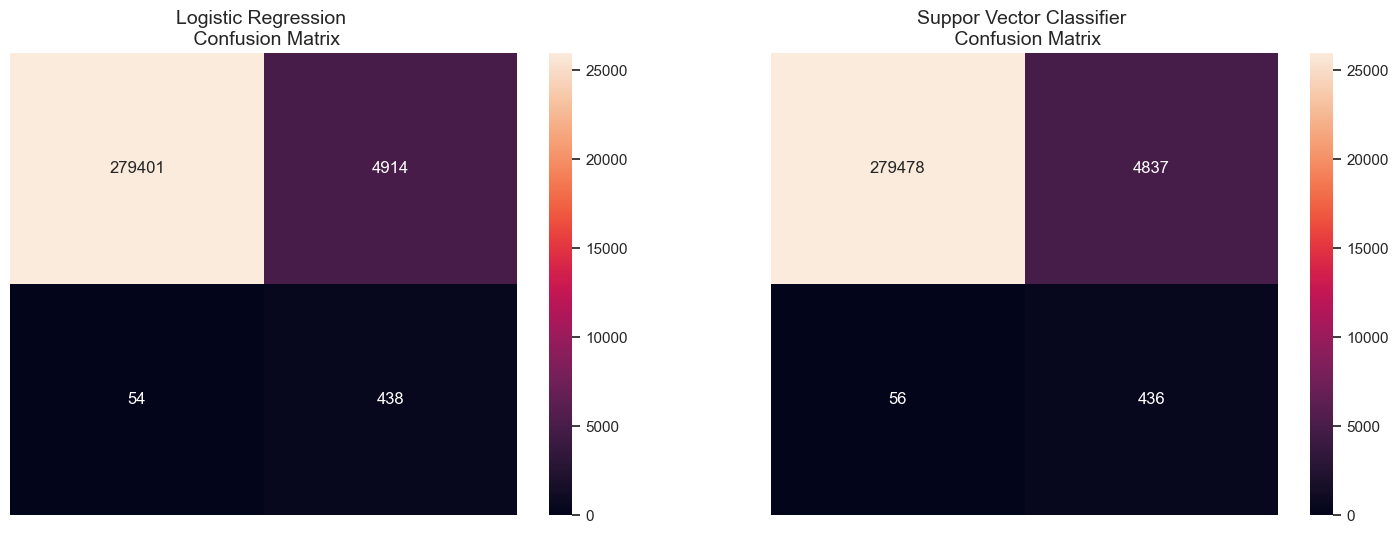

In [51]:
from sklearn.metrics import confusion_matrix

y_pred_logreg_original = logreg.predict(X)
y_pred_svc_original = svc.predict(X)


log_reg_cf = confusion_matrix(y, y_pred_logreg_original)
svc_cf = confusion_matrix(y, y_pred_svc_original)

print(log_reg_cf)
print(svc_cf)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,6))

sns.heatmap(log_reg_cf, ax=ax1,vmin=0, vmax=26000, annot=True, fmt='g')
ax1.set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax1.set_xticklabels(['', ''], fontsize=8, rotation=90)
ax1.set_yticklabels(['', ''], fontsize=8, rotation=360)

sns.heatmap(svc_cf, ax=ax2,vmin=0,vmax=26000, annot=True, fmt='g')
ax2.set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax2.set_xticklabels(['', ''], fontsize=8, rotation=90)
ax2.set_yticklabels(['', ''], fontsize=8, rotation=360)

plt.show()

In [52]:
print(classification_report(y,y_pred_logreg_original))
print(classification_report(y,y_pred_svc_original))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    284315
           1       0.08      0.89      0.15       492

    accuracy                           0.98    284807
   macro avg       0.54      0.94      0.57    284807
weighted avg       1.00      0.98      0.99    284807

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    284315
           1       0.08      0.89      0.15       492

    accuracy                           0.98    284807
   macro avg       0.54      0.93      0.57    284807
weighted avg       1.00      0.98      0.99    284807

